# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import os
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../input/train_macro.csv', index_col=0, parse_dates=['timestamp'])
df_test_macro = pd.read_csv('../input/test_macro.csv', index_col=0, parse_dates=['timestamp'])

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns.drop('_timestamp')) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     493.5
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:50:59   Log-Likelihood:                -19194.
No. Observations:               30404   AIC:                         3.848e+04
Df Residuals:                   30358   BIC:                         3.886e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0053      0.002      3.521      0.000       0.002       0.008
C(_nuclear_reactor_raion)[T.yes]                          -0.0009      0.001     -1.010      0.313      -0.003       0.001
C(_culture_objects_top_25)[T.yes]                         -0.0043      0.001     -4.008      0.000      -0.006      -0.002
C(_railroad_1line)[T.yes]                                 -0.0047      0.001     -4.721      0.000      -0.007      -0.003
C(_railroad_terminal_raion)[T.yes]                         0.0025      0.001      2.468      0.014       0.001       0.004
C(_thermal_power_plant_raion)[T.yes]                       0.0030      0.002      1.901      0.057   -9.13e-05       0.006
C(_detention_facility_raion)[T.yes]                        0.0009      0.001      0.637      0.524      -0.002       0.004
C(_radiation_raion)[T.yes]                                -0.0115      0.003     -3.863      0.000      -0.017      -0.006
C(_product_type)[T.OwnerOccupier]                          0.0054      0.002      3.277      0.001       0.002       0.009
C(_oil_chemistry_raion)[T.yes]                             0.0003      0.001      0.451      0.652      -0.001       0.001
C(_big_market_raion)[T.yes]                                0.0008      0.001      0.609      0.543      -0.002       0.003
C(_ecology)[T.good]                                        0.0025      0.002      1.143      0.253      -0.002       0.007
C(_ecology)[T.no data]                                  3.208e-05      0.001      0.050      0.960      -0.001       0.001
C(_ecology)[T.poor]                                        0.0037      0.004      1.054      0.292      -0.003       0.011
C(_ecology)[T.satisfactory]                               -0.0071      0.002     -3.619      0.000      -0.011      -0.003
C(_big_road1_1line)[T.yes]                                -0.0019      0.001     -2.320      0.020      -0.004      -0.000
C(_water_1line)[T.yes]                                    -0.0010      0.001     -0.765      0.445      -0.003       0.002
C(_incineration_raion)[T.yes]                             -0.0013      0.001     -1.313      0.189      -0.003       0.001
np.log(_full_sq)                                           0.0119      0.000     54.694      0.000       0.011       0.012
np.log(_life_sq)                                          -0.0100      0.001     -9.704      0.000      -0.012      -0.008
_floor                                                     0.0090      0.002      5.795      0.000       0.006       0.012
np.log(_num_room)                                          0.0046      0.000     10.294      0.000       0.004       0.005
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     61.89
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:53:26   Log-Likelihood:                -18889.
No. Observations:               30404   AIC:                         3.852e+04
Df Residuals:                   30031   BIC:                         4.163e+04
Df Model:                         372                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5739      0.029    530.697      0.000      15.516      15.631
C(_nuclear_reactor_raion)[T.yes]                                  0.0202      0.036      0.566      0.571      -0.050       0.090
C(_culture_objects_top_25)[T.yes]                                 0.0355      0.029      1.216      0.224      -0.022       0.093
C(_railroad_1line)[T.yes]                                        -0.0663      0.020     -3.247      0.001      -0.106      -0.026
C(_railroad_terminal_raion)[T.yes]                                0.0708      0.040      1.763      0.078      -0.008       0.149
C(_thermal_power_plant_raion)[T.yes]                             -0.0551      0.028     -1.950      0.051      -0.110       0.000
C(_detention_facility_raion)[T.yes]                               0.0199      0.023      0.866      0.387      -0.025       0.065
C(_radiation_raion)[T.yes]                                       -0.0471      0.015     -3.104      0.002      -0.077      -0.017
C(_product_type)[T.OwnerOccupier]                                 0.1438      0.013     10.737      0.000       0.118       0.170
C(_oil_chemistry_raion)[T.yes]                                   -0.0111      0.055     -0.203      0.839      -0.119       0.096
C(_big_market_raion)[T.yes]                                       0.0498      0.029      1.729      0.084      -0.007       0.106
C(_ecology)[T.good]                                              -0.0337      0.031     -1.103      0.270      -0.094       0.026
C(_ecology)[T.no data]                                            0.0570      0.071      0.800      0.424      -0.083       0.197
C(_ecology)[T.poor]                                              -0.0493      0.021     -2.314      0.021      -0.091      -0.008
C(_ecology)[T.satisfactory]                                      -0.0569      0.029     -1.943      0.052      -0.114       0.000
C(_big_road1_1line)[T.yes]                                       -0.0393      0.020     -1.934      0.053      -0.079       0.001
C(_water_1line)[T.yes]                                           -0.0054      0.013     -0.409      0.682      -0.031       0.021
C(_incineration_raion)[T.yes]                                     0.1312      0.042      3.104      0.002       0.048       0.214
scale(np.log(_full_sq))                                           0.0093      0.045      0.208      0.835      -0.078       0.097
scale(np.log(_life_sq))                                           0.0224      0.018      1.260      0.208      -0.012       0.057
scale(_floor)                                                     0.0424      0.008      5.17

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_nuclear_reactor_raion),0.065841,1.0,0.320609,5.712461e-01
C(_culture_objects_top_25),0.303650,1.0,1.478599,2.240034e-01
C(_railroad_1line),2.164743,1.0,10.541055,1.168798e-03
C(_railroad_terminal_raion),0.638386,1.0,3.108571,7.789141e-02
C(_thermal_power_plant_raion),0.780613,1.0,3.801135,5.122714e-02
C(_detention_facility_raion),0.153923,1.0,0.749519,3.866356e-01
C(_radiation_raion),1.978789,1.0,9.635566,1.910228e-03
C(_product_type),23.675208,1.0,115.284652,7.627425e-27
C(_oil_chemistry_raion),0.008465,1.0,0.041219,8.391173e-01
C(_big_market_raion),0.613639,1.0,2.988069,8.389043e-02



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     299.9
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:59:21   Log-Likelihood:                -19634.
No. Observations:               30404   AIC:                         3.941e+04
Df Residuals:                   30334   BIC:                         3.999e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5694      0.005   2869.099      0.000      15.559      15.580
C(_railroad_1line)[T.yes]                                        -0.1119      0.018     -6.269      0.000      -0.147      -0.077
C(_radiation_raion)[T.yes]                                       -0.0257      0.008     -3.293      0.001      -0.041      -0.010
C(_product_type)[T.OwnerOccupier]                                 0.1432      0.010     14.085      0.000       0.123       0.163
C(_incineration_raion)[T.yes]                                     0.0434      0.021      2.067      0.039       0.002       0.085
scale(_floor)                                                     0.0423      0.008      5.176      0.000       0.026       0.058
scale(_state)                                                    -0.2133      0.015    -13.974      0.000      -0.243      -0.183
scale(_school_education_centers_raion)                            0.0266      0.006      4.102      0.000       0.014       0.039
scale(np.log(_university_top_20_raion))                           0.0649      0.021      3.114      0.002       0.024       0.106
scale(np.log(_raion_build_count_with_material_info))            -26.3826      4.034     -6.540      0.000     -34.290     -18.476
scale(np.log(_raion_build_count_with_builddate_info))            26.4720      4.044      6.546      0.000      18.545      34.399
scale(np.log(_build_count_before_1920))                          -0.0173      0.005     -3.176      0.001      -0.028      -0.007
scale(np.log(_school_km))                                         0.0522      0.018      2.956      0.003       0.018       0.087
scale(np.log(_railroad_station_walk_min))                         0.0641      0.019      3.338      0.001       0.026       0.102
scale(np.log(_public_transport_station_min_walk))                -0.0122      0.004     -2.849      0.004      -0.021      -0.004
scale(np.log(_kremlin_km))                                        0.2064      0.013     15.686      0.000       0.181       0.232
scale(np.log(_zd_vokzaly_avto_km))                                0.0869      0.016      5.433      0.000       0.056       0.118
scale(np.log(_additional_education_km))                          -0.0283      0.004     -6.668      0.000      -0.037      -0.020
scale(np.log(_preschool_km))                                     -0.0541      0.017     -3.139      0.002      -0.088      -0.020
scale(np.log(_big_church_km))                                    -0.0130      0.005     -2.516      0.012      -0.023      -0.003
scale(np.log(_cafe_count_1000_price_1000))                        0.0218      0.007      3.23

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     3062.
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:00:21   Log-Likelihood:                 14483.
No. Observations:               26696   AIC:                        -2.883e+04
Df Residuals:                   26626   BIC:                        -2.825e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.7533      0.002   8346.080      0.000      15.750      15.757
C(_railroad_1line)[T.yes]                                        -0.1097      0.006    -17.820      0.000      -0.122      -0.098
C(_radiation_raion)[T.yes]                                       -0.0136      0.003     -5.194      0.000      -0.019      -0.008
C(_product_type)[T.OwnerOccupier]                                -0.0651      0.003    -19.238      0.000      -0.072      -0.058
C(_incineration_raion)[T.yes]                                     0.0359      0.007      5.119      0.000       0.022       0.050
scale(_floor)                                                     0.0598      0.003     21.181      0.000       0.054       0.065
scale(_state)                                                    -0.1730      0.005    -34.782      0.000      -0.183      -0.163
scale(_school_education_centers_raion)                            0.0292      0.002     13.215      0.000       0.025       0.033
scale(np.log(_university_top_20_raion))                          -0.0255      0.008     -3.349      0.001      -0.040      -0.011
scale(np.log(_raion_build_count_with_material_info))            -17.0857      1.369    -12.479      0.000     -19.769     -14.402
scale(np.log(_raion_build_count_with_builddate_info))            17.1256      1.373     12.477      0.000      14.435      19.816
scale(np.log(_build_count_before_1920))                          -0.0193      0.002    -10.844      0.000      -0.023      -0.016
scale(np.log(_school_km))                                         0.0223      0.006      3.554      0.000       0.010       0.035
scale(np.log(_railroad_station_walk_min))                         0.0485      0.006      7.498      0.000       0.036       0.061
scale(np.log(_public_transport_station_min_walk))                -0.0065      0.001     -4.515      0.000      -0.009      -0.004
scale(np.log(_kremlin_km))                                        0.1491      0.005     31.008      0.000       0.140       0.159
scale(np.log(_zd_vokzaly_avto_km))                                0.0622      0.006      9.617      0.000       0.050       0.075
scale(np.log(_additional_education_km))                          -0.0052      0.001     -3.656      0.000      -0.008      -0.002
scale(np.log(_preschool_km))                                     -0.0233      0.006     -3.805      0.000      -0.035      -0.011
scale(np.log(_big_church_km))                                    -0.0111      0.002     -6.444      0.000      -0.014      -0.008
scale(np.log(_cafe_count_1000_price_1000))                        0.0369      0.002     16.56

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     5952.
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:00:37   Log-Likelihood:                 16847.
No. Observations:               24976   AIC:                        -3.361e+04
Df Residuals:                   24935   BIC:                        -3.328e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       15.7473      0.001   1.07e+04      0.000      15.744      15.750
C(_railroad_1line)[T.yes]                                       -0.1495      0.005    -27.666      0.000      -0.160      -0.139
C(_product_type)[T.OwnerOccupier]                               -0.0691      0.003    -22.701      0.000      -0.075      -0.063
scale(_floor)                                                    0.0528      0.003     20.406      0.000       0.048       0.058
scale(_state)                                                    0.0098      0.001      8.887      0.000       0.008       0.012
scale(_school_education_centers_raion)                           0.0353      0.002     20.568      0.000       0.032       0.039
scale(np.log(_raion_build_count_with_material_info))             0.0037      0.004      0.991      0.322      -0.004       0.011
scale(np.log(_build_count_before_1920))                         -0.0192      0.001    -13.402      0.000      -0.022      -0.016
scale(np.log(_railroad_station_walk_min))                       -0.0153      0.001    -13.866      0.000      -0.017      -0.013
scale(np.log(_public_transport_station_min_walk))               -0.0023      0.001     -1.945      0.052      -0.005     1.8e-05
scale(np.log(_kremlin_km))                                       0.0737      0.003     28.811      0.000       0.069       0.079
scale(np.log(_zd_vokzaly_avto_km))                              -0.0476      0.002    -21.423      0.000      -0.052      -0.043
scale(np.log(_big_church_km))                                   -0.0076      0.001     -5.680      0.000      -0.010      -0.005
scale(np.log(_cafe_count_1000_price_1000))                       0.0472      0.002     25.380      0.000       0.044       0.051
scale(np.log(_leisure_count_1000))                               0.0057      0.001      5.059      0.000       0.003       0.008
scale(np.log(_office_sqm_1500))                                 -0.0204      0.001    -15.835      0.000      -0.023      -0.018
scale(np.log(_trc_count_2000))                                   0.0192      0.002     10.461      0.000       0.016       0.023
scale(np.log(_cafe_count_2000_price_1500))                       0.0135      0.002      6.771      0.000       0.010       0.017
scale(np.log(_office_sqm_5000))                                  0.0275      0.002     18.060      0.000       0.024       0.030
scale(np.log(_cafe_count_5000_price_high))                       0.0231      0.002     13.929      0.000       0.020       0.026
scale(np.log(_mosque_count_5000))                                0.0028      0.001      2.953      0.003       0.001

# 5. Diagnosis of Regression
## Residual Normality Test

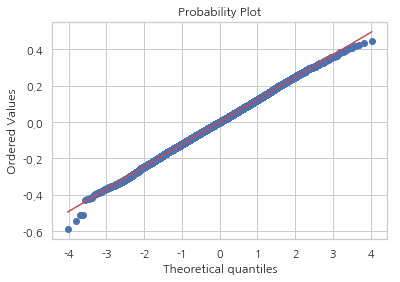

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.182
P-value     :  0.204


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

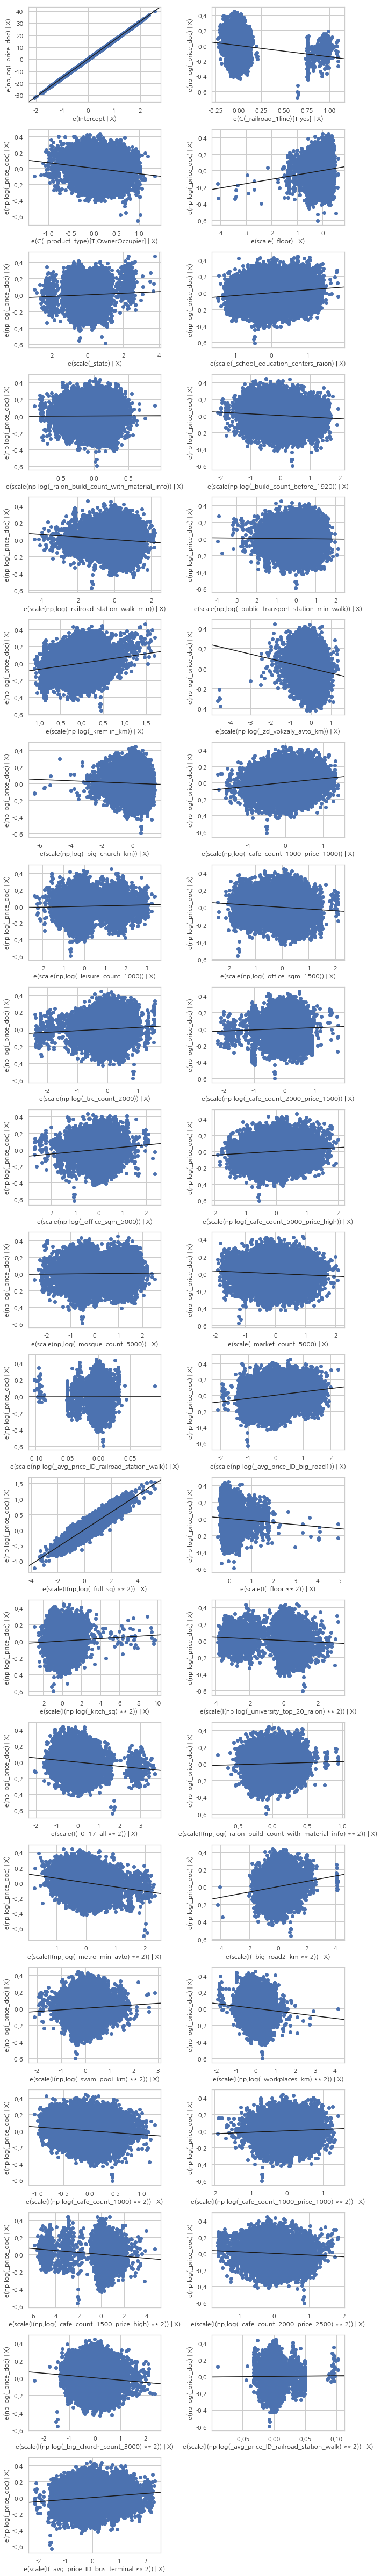

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.3790554450056386

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         2.,  1.,  4.,  2.,  4.,  3.,  1.,  7.,  2.,  6.,  7.,  3., 10.,
        13., 11., 10., 15., 16.,  8., 14., 17., 16.,  7., 14., 23., 24.,
        19., 25., 27., 29., 31., 35., 28., 38., 32., 29., 34., 22., 34.,
        35., 25., 29., 34., 21., 19., 25., 32., 11., 23., 15., 15.,  9.,
        20., 13.,  8.,  8.,  6.,  5.,  5.,  6.,  3.]),
 array([-0.85389625, -0.83695292, -0.8200096 , -0.80306627, -0.78612294,
        -0.76917961, -0.75223629, -0.73529296, -0.71834963, -0.7014063 ,
        -0.68446298, -0.66751965, -0.65057632, -0.63363299, -0.61668967,
        -0.59974634, -0.58280301, -0.56585968, -0.54891635, -0.53197303,
        -0.5150297 , -0.49808637, -0.48114304, -0.46419972, -0.44725639,
        -0.43031306, -0.41336973, -0.39642641, -0.37948308, -0.362539

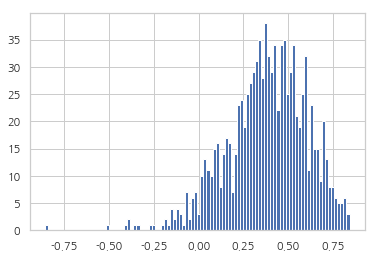

In [16]:
plt.hist(r2s, bins=100)

In [25]:
df_test_macro.head(2)

,_timestamp,_full_sq,_life_sq,_floor,_num_room,_kitch_sq,_state,_product_type,_area_m,_raion_popul,_preschool_education_centers_raion,_school_education_centers_raion,_school_education_centers_top_20_raion,_hospital_beds_raion,_healthcare_centers_raion,_university_top_20_raion,_sport_objects_raion,_culture_objects_top_25,_shopping_centers_raion,_office_raion,_thermal_power_plant_raion,_incineration_raion,_oil_chemistry_raion,_radiation_raion,_railroad_terminal_raion,_big_market_raion,_nuclear_reactor_raion,_detention_facility_raion,_young_all,_work_all,_ekder_all,_0_17_all,_raion_build_count_with_material_info,_build_count_brick,_build_count_monolith,_raion_build_count_with_builddate_info,_build_count_before_1920,_metro_min_avto,_metro_min_walk,_kindergarten_km,_school_km,_park_km,_railroad_station_walk_min,_railroad_station_avto_min,_public_transport_station_min_walk,_water_1line,_ttk_km,_sadovoe_km,_bulvar_ring_km,_kremlin_km,_big_road1_km,_big_road1_1line,_big_road2_km,_railroad_1line,_zd_vokzaly_avto_km,_bus_terminal_avto_km,_oil_chemistry_km,_nuclear_reactor_km,_radiation_km,_power_transmission_line_km,_thermal_power_plant_km,_ts_km,_market_shop_km,_fitness_km,_swim_pool_km,_ice_rink_km,_stadium_km,_basketball_km,_hospice_morgue_km,_detention_facility_km,_public_healthcare_km,_university_km,_workplaces_km,_shopping_centers_km,_office_km,_additional_education_km,_preschool_km,_big_church_km,_church_synagogue_km,_mosque_km,_theater_km,_museum_km,_exhibition_km,_catering_km,_ecology,_office_count_500,_office_sqm_500,_cafe_count_500,_cafe_count_500_price_1000,_cafe_count_500_price_1500,_leisure_count_500,_office_count_1000,_office_sqm_1000,_cafe_count_1000,_cafe_count_1000_na_price,_cafe_count_1000_price_1000,_cafe_count_1000_price_1500,_cafe_count_1000_price_high,_leisure_count_1000,_sport_count_1000,_office_count_1500,_office_sqm_1500,_trc_count_1500,_cafe_count_1500,_cafe_sum_1500_min_price_avg,_cafe_sum_1500_max_price_avg,_cafe_avg_price_1500,_cafe_count_1500_na_price,_cafe_count_1500_price_500,_cafe_count_1500_price_1000,_cafe_count_1500_price_1500,_cafe_count_1500_price_2500,_cafe_count_1500_price_high,_mosque_count_1500,_leisure_count_1500,_sport_count_1500,_green_part_2000,_office_count_2000,_office_sqm_2000,_trc_count_2000,_trc_sqm_2000,_cafe_count_2000,_cafe_sum_2000_max_price_avg,_cafe_count_2000_na_price,_cafe_count_2000_price_500,_cafe_count_2000_price_1000,_cafe_count_2000_price_1500,_cafe_count_2000_price_2500,_cafe_count_2000_price_high,_mosque_count_2000,_sport_count_2000,_market_count_2000,_green_part_3000,_office_count_3000,_office_sqm_3000,_trc_count_3000,_trc_sqm_3000,_cafe_count_3000,_cafe_count_3000_na_price,_cafe_count_3000_price_500,_cafe_count_3000_price_1000,_cafe_count_3000_price_1500,_cafe_count_3000_price_2500,_cafe_count_3000_price_4000,_cafe_count_3000_price_high,_big_church_count_3000,_church_count_3000,_leisure_count_3000,_sport_count_3000,_market_count_3000,_green_part_5000,_office_count_5000,_office_sqm_5000,_trc_count_5000,_trc_sqm_5000,_cafe_count_5000,_cafe_count_5000_na_price,_cafe_count_5000_price_500,_cafe_count_5000_price_1000,_cafe_count_5000_price_1500,_cafe_count_5000_price_2500,_cafe_count_5000_price_4000,_cafe_count_5000_price_high,_big_church_count_5000,_church_count_5000,_mosque_count_5000,_leisure_count_5000,_sport_count_5000,_market_count_5000,_yearweek,_room_size,_avg_price_ID_metro,_avg_price_ID_railroad_station_walk,_avg_price_ID_big_road1,_avg_price_ID_big_road2,_avg_price_ID_railroad_terminal,_avg_price_ID_bus_terminal,_avg_price_sub_area,_gdp_quart,_gdp_quart_growth,_cpi,_ppi,_gdp_deflator,_usdrub,_eurrub,_gdp_annual,_average_provision_of_build_contract,_rts,_micex_cbi_tr,_deposits_value,_grp,_grp_growth,_salary,_salary_growth,_fixed_basket,_retail_trade_turnover,_retail_trade_turnover_per_cap,_retail_trade_turnover_growth,_labor_force,_employment,_invest_fixed_capital_per_cap,_invest_fixed_assets,_profitable_enterpr_share,_unprofitable_enterpr_share,_share_own_revenues

In [22]:
np.exp(result.predict(df_test_macro))

id
30474    5.350325e+06
30475    8.315417e+06
30476    6.163401e+06
30477    6.252961e+06
30478    4.911932e+06
30479    7.214161e+06
30480    4.743731e+06
30481    3.959956e+06
30482    5.170550e+06
30483    4.190328e+06
30484    6.210036e+06
30485    4.817833e+06
30486    3.531855e+06
30487    4.184768e+06
30488    5.137020e+06
30489    6.846274e+06
30490    1.753176e+07
30491    1.717487e+07
30492    6.248220e+06
30493    1.565615e+07
30494    6.971375e+06
30495    1.217466e+07
30496    9.057347e+06
30497    9.938331e+06
30498    4.898003e+06
30499    1.039079e+07
30500    1.028829e+07
30501    7.296638e+06
30502    3.039945e+06
30503    6.825227e+06
30504    7.387857e+06
30505    1.242508e+07
30506    2.929501e+06
30507    4.405993e+06
30508    5.770198e+06
30509    7.500965e+06
30510    8.900945e+06
30511    6.938076e+06
30512    7.531658e+06
30513    4.886871e+06
30514    3.575703e+06
30515    8.947765e+06
30516    5.573613e+06
30517    8.839241e+06
30518    6.965150e+06
30519  

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('../submissions/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

RMSLE : 0.36548

In [18]:
for col in df_train_macro_with_outliers.columns:
    df_train_macro_with_outliers.rename(columns={col:col[1:]}, inplace=True)
for col in df_train_macro.columns:
    df_train_macro.rename(columns={col:col[1:]}, inplace=True)
df_train_macro_with_outliers.to_csv('../input/train_macro_with_outliers.csv', header=True, index=True)
df_train_macro.to_csv('../input/train_macro_without_outliers.csv', header=True, index=True)